In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# for displaying variables w/o print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# <a id='0'> Data Cleaning and Preprocessing

## Highlights
- <a href='#cov'>Data Mining: Extract the Incubation time of COVID-19 from Literature
- <a href='#re'>Regular Expression: Automatically Extract Emails from Large Texts



## Contents
<a href='#1'>1. Handling Anomalies<br></a>
Missing Values, Duplicates and Outliers: Detect, Drop and Replace.<br></a>

<a href='#2'>2. Data Tranformation</a>
- Element-wise: Mapping, Replacing, Renaming<br>
- Inter-Conversion b/t Numerical and Categorical<br>
    - Discretization and Binning: numerical to categorical <br>
    - Dummy variables: categorical to numerical<br>

<a href='#3'>3. String Manipulation</a><br>
- Python String Methods
- Python Regular Expression (RE)
- Pandas Vectorized String Methods

## 1. Handling Anomalies
### Missing Values
Key operations: Detect, Drop and Fill in.

In [7]:
s1 = ['avocado', 'artichoke', None]  # 'None' is a Python keyword for a missing value.
s2 = [None,       'orange',    None]
df = pd.DataFrame({'col1':s1, 'col2': s2})
df

,col1,col2
0,avocado,None
1,artichoke,orange
2,None,None


#### Detect
##### print rows/columns with NA
Note: use df.loc[ ] to access rows, df[ ] to access columns

In [8]:
bool_na_df = df.isna()  # create a boolean df

df.loc[bool_na_df.any(axis=1)]        # rows with at least one NA
df.loc[bool_na_df.sum(axis=1) >= 2]   # rows with at least two NAs

df[df.columns[bool_na_df.any(axis=0)]] # columns with at least one NA

,col1,col2
0,avocado,None
2,None,None


,col1,col2
2,None,None


,col1,col2
0,avocado,None
1,artichoke,orange
2,None,None


##### Calculate the portion of missing values for each column

In [11]:
bool_na_df.sum(axis=0) / len(df)

col1    0.333333
col2    0.666667
dtype: float64

#### Drop empty rows

In [9]:
df.dropna(axis=0, how='all') # drop empty rows, use 'axis=1' for empty columns

,col1,col2
0,avocado,None
1,artichoke,orange


##### Drop columns if there are less than 90% good values
ft. df.dropna(thresh=)

In [34]:
df = pd.DataFrame(np.random.randn(5, 3), columns=['A','B','C'])
df.iloc[:4, 1] = np.nan
df.iloc[:2, 2] = np.nan
df
df.dropna(axis=1, thresh=int(0.9*len(df))) # Solution

,A,B,C
0,-1.662997,NaN,NaN
1,-1.706950,NaN,NaN
2,-0.455346,NaN,0.344418
3,0.641348,NaN,-0.213904
4,0.711611,0.874748,0.242051


,A
0,-1.662997
1,-1.706950
2,-0.455346
3,0.641348
4,0.711611


#### Fill in

##### Series: fill in NAs with the mean

In [10]:
s = pd.Series([1., np.nan, 3.5, np.nan, 7]) # np.nan as NA
s
s.fillna(s.mean())  # Solution

0    1.0
1    NaN
2    3.5
3    NaN
4    7.0
dtype: float64

0    1.000000
1    3.833333
2    3.500000
3    3.833333
4    7.000000
dtype: float64

##### DataFrame: fill in NAs differently for each column

In [12]:
df = pd.DataFrame(np.random.randn(5, 3), columns=list('ABC'))
df.iloc[[2,4], 1] = np.nan
df.iloc[4:, 2]    = np.nan
df

,A,B,C
0,2.483679,1.263230,0.325474
1,-0.506194,-1.057470,0.488248
2,3.105346,NaN,-0.269142
3,-0.006844,-1.750611,0.718988
4,1.327416,NaN,NaN


##### fill in NA with the column mean respectively

In [14]:
df.apply(lambda s: s.fillna(s.mean()))

,A,B,C
0,2.483679,1.263230,0.325474
1,-0.506194,-1.057470,0.488248
2,3.105346,-0.514950,-0.269142
3,-0.006844,-1.750611,0.718988
4,1.327416,-0.514950,0.315892


##### fill in NAs differently for each column

In [16]:
df.fillna({'A': 0.5, 'C': 0})  # use a dictionary

,A,B,C
0,2.483679,1.263230,0.325474
1,-0.506194,-1.057470,0.488248
2,3.105346,NaN,-0.269142
3,-0.006844,-1.750611,0.718988
4,1.327416,NaN,0.000000


### Duplicates

In [17]:
df = pd.DataFrame({'A': ['one', 'two']*2 + ['two'],
                   'B': [1, 2, 3, 4, 4],
                   'C': [1, 2, 3, 4, 4]})
df

,A,B,C
0,one,1,1
1,two,2,2
2,one,3,3
3,two,4,4
4,two,4,4


#### Detect and Drop

##### Duplicated rows

In [18]:
# Detect
df.duplicated()

# Drop 
df.drop_duplicates()      # drop rows

0    False
1    False
2    False
3    False
4     True
dtype: bool

,A,B,C
0,one,1,1
1,two,2,2
2,one,3,3
3,two,4,4


##### Duplicated columns

In [19]:
# Detect
df.T.duplicated()

# Drop 
df.T.drop_duplicates().T

A    False
B    False
C     True
dtype: bool

,A,B
0,one,1
1,two,2
2,one,3
3,two,4
4,two,4


### Outliers
#### Detect

In [20]:
df = pd.DataFrame(
     [[14, 1,  0, 1],
      [ 2, 2,  3, 3],
      [-15,1, 16, 2]
     ],
    columns=['A','B','C','D']
)
df

,A,B,C,D
0,14,1,0,1
1,2,2,3,3
2,-15,1,16,2


##### find all rows containing at least one outlier ( e.g. |x|> 3 )

In [21]:
bool_outlier_df = np.abs(df) > 3  # similar to handling missing values, create a boolean DataFrame
df.loc[bool_outlier_df.any(axis=1)]

,A,B,C,D
0,14,1,0,1
2,-15,1,16,2


#### Cap: replace the outliers with a capped value.

In [46]:
df[bool_outlier_df] = np.sign(df) * 3  # nice trick !
df

,a,b,c,d
0,3,1,0,1
1,2,2,3,3
2,-3,1,3,2


## <a id='2'>Data Transformation
### Mapping & Replacing</a>
<a href='#0'> Back to TOC

### Mapping in Series
Mapping: One-to-One transformation
- Element-wise transformation, using a function, a dictionary or a Series. <br>
- Recommend: operating on a Series instead of the whole DataFrame, since the latter is more likely to cause unwanted results.
- Tips: it requires all the values to be mapped, otherwise it creates NAs

In [23]:
df = pd.DataFrame({'food'  : ['bacon'   , 'pulled pork', 'bacon',
                              'pastrami', 'corned beef', 'bacon'],
                   'ounces': [4, 3, 12, 6, 7.5, 8]
                  })
df

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,pastrami,6.0
4,corned beef,7.5
5,bacon,8.0


In [24]:
meat_to_animal = {
  'bacon'      : 'pig', 'pastrami'   : 'cow',
  'pulled pork': 'pig', 'corned beef': 'cow'}

df['food'].map(meat_to_animal)  # using a dictionary

0    pig
1    pig
2    pig
3    cow
4    cow
5    pig
Name: food, dtype: object

In [26]:
s = pd.Series(meat_to_animal)
df['food'].map(s)  # using a Series

0    pig
1    pig
2    pig
3    cow
4    cow
5    pig
Name: food, dtype: object

### Replacing Values
Similar to mapping, but it can be used to replace only a subset of all possible values, unlike mapping, which requires a complete mapping of all values. It's commonly used to assist fillna( ) to replace abnormal values that is not 'NA'.

In [30]:
df = pd.read_csv('examples/weather.csv')
df

,day,temperature,windspeed,event
0,1/1/2017,32,6,Rain
1,1/5/2017,-99999,7,Sunny
2,1/6/2017,28,-999,Snow
3,1/7/2017,-99999,7,0
4,1/8/2017,32,-999,Rain


In [20]:
df['temperature'].replace(-99999, np.nan)
df.replace([-99999, -999], np.nan)

0    32.0
1     NaN
2    28.0
3     NaN
4    32.0
Name: temperature, dtype: float64

,day,temperature,windspeed,event
0,1/1/2017,32.0,6.0,Rain
1,1/2/2017,NaN,7.0,Sunny
2,1/3/2017,28.0,NaN,Snow
3,1/4/2017,NaN,7.0,0
4,1/5/2017,32.0,NaN,Rain


Column-specific replace

In [21]:
df.replace({'temperature':-99999, 
            'windspeed': -999,
            'event':'0'}, 
           np.nan)

,day,temperature,windspeed,event
0,1/1/2017,32.0,6.0,Rain
1,1/2/2017,NaN,7.0,Sunny
2,1/3/2017,28.0,NaN,Snow
3,1/4/2017,NaN,7.0,NaN
4,1/5/2017,32.0,NaN,Rain


Value-specific replace

In [22]:
df.replace({-99999: np.nan,
            -999: 0,
            '0': 'Cloudy'})           

,day,temperature,windspeed,event
0,1/1/2017,32.0,6.0,Rain
1,1/2/2017,NaN,7.0,Sunny
2,1/3/2017,28.0,0.0,Snow
3,1/4/2017,NaN,7.0,Cloudy
4,1/5/2017,32.0,0.0,Rain


Replace with regular expression (also see regular expression in <a href='#3'>String Manipulation )

In [25]:
df2 = df.copy()
df2.loc[1, 'temperature'] = '30 F'
df2.loc[2, 'windspeed'] = '5 mph'

df2

df2.replace({
    'temperature': '[A-Za-z]',
    'windspeed'  : '[A-Za-z]'
    }, '',   # remove the letters in these two columns
    regex=True)

,day,temperature,windspeed,event
0,1/1/2017,32,6,Rain
1,1/2/2017,30 F,7,Sunny
2,1/3/2017,28,5 mph,Snow
3,1/4/2017,-99999,7,0
4,1/5/2017,32,-999,Rain


,day,temperature,windspeed,event
0,1/1/2017,32,6,Rain
1,1/2/2017,30,7,Sunny
2,1/3/2017,28,5,Snow
3,1/4/2017,-99999,7,0
4,1/5/2017,32,-999,Rain


### Interpolate: fill in NAs with interpolated values
df.interpolate( ) vs df.fillna( )

In [43]:
df3 = df.replace([-99999,-999],np.nan)
df3

,day,temperature,windspeed,event
0,1/1/2017,32.0,6.0,Rain
1,1/5/2017,NaN,7.0,Sunny
2,1/6/2017,28.0,NaN,Snow
3,1/7/2017,NaN,7.0,0
4,1/8/2017,32.0,NaN,Rain


In [44]:
df3['day'] = pd.to_datetime(df3['day'])
df3.set_index('day', inplace=True)

In [48]:
df3.interpolate(method='linear')

,temperature,windspeed,event
day,,,
2017-01-01,32.0,6.0,Rain
2017-01-05,30.0,7.0,Sunny
2017-01-06,28.0,7.0,Snow
2017-01-07,30.0,7.0,0
2017-01-08,32.0,7.0,Rain


In [45]:
df3.interpolate(method='time')  # interpolate NAs based on the DatetimeIndex.

,temperature,windspeed,event
day,,,
2017-01-01,32.0,6.0,Rain
2017-01-05,28.8,7.0,Sunny
2017-01-06,28.0,7.0,Snow
2017-01-07,30.0,7.0,0
2017-01-08,32.0,7.0,Rain


In [46]:
df3.fillna(method='ffill')

,temperature,windspeed,event
day,,,
2017-01-01,32.0,6.0,Rain
2017-01-05,32.0,7.0,Sunny
2017-01-06,28.0,7.0,Snow
2017-01-07,28.0,7.0,0
2017-01-08,32.0,7.0,Rain


In [49]:
df3.fillna(method='bfill')

,temperature,windspeed,event
day,,,
2017-01-01,32.0,6.0,Rain
2017-01-05,28.0,7.0,Sunny
2017-01-06,28.0,7.0,Snow
2017-01-07,32.0,7.0,0
2017-01-08,32.0,NaN,Rain


### Renaming Axis Indexes
Rename: a convenience function for mapping index values and column labels

In [28]:
df = pd.DataFrame(np.arange(12).reshape((3, 4)),
                  index=['ohio', 'colorado', 'new york'],
                  columns=['a', 'b', 'c', 'd'])
df

,a,b,c,d
ohio,0,1,2,3
colorado,4,5,6,7
new york,8,9,10,11


In [29]:
df.rename(index={'ohio':'Ohio'}, columns=str.upper, inplace=False)

,A,B,C,D
Ohio,0,1,2,3
colorado,4,5,6,7
new york,8,9,10,11


#### <a id='rename'>Task: convert the first row of the DataFrame to header
<a href='#0'> Back to TOC

In [30]:
raw_data = {
    '0': ['first_name', 'Molly', 'Tina', 'Jake', 'Amy'], 
    '1': ['last_name', 'Jacobson', 'Ali', 'Milner', 'Cooze'], 
    '2': ['age', 52, 36, 24, 73], 
    '3': ['preTestScore', 24, 31, 2, 3]}

df = pd.DataFrame(raw_data)
df.head(3)

,0,1,2,3
0,first_name,last_name,age,preTestScore
1,Molly,Jacobson,52,24
2,Tina,Ali,36,31


In [31]:
header = df.iloc[0] # return a Series, dictionary-like

df.drop(index=0, inplace=True) # drop the first row
df.rename(columns=header, inplace=True)
df.head(2)

,first_name,last_name,age,preTestScore
1,Molly,Jacobson,52,24
2,Tina,Ali,36,31


### <a id='22'>Discretization and Binning
ft. pd.cut( ) and pd.qcut( ) <br>
    
Converting numerical data to categorical data is a commonly used operation in data analysis, especially at the earlier stage of data exploration. It reduces the complexity (and size) of the data, and helps the discovery of new relationships between variables.

<a href='#0'> Back to TOC

#### pd.cut( )

In [32]:
# cut a list of values into categories
age_data = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]
bins = [18, 25, 35, 60, 100]

age_cat = pd.cut(age_data, bins)
type(age_cat)
age_cat.categories, age_cat.codes

# pass an integer
pd.cut(age_data, 4).categories

# label the categories
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']
pd.cut(age_data, bins, labels=group_names).categories

pandas.core.arrays.categorical.Categorical

(IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]]
               closed='right',
               dtype='interval[int64]'),
 array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8))

IntervalIndex([(19.959, 30.25], (30.25, 40.5], (40.5, 50.75], (50.75, 61.0]]
              closed='right',
              dtype='interval[float64]')

Index(['Youth', 'YoungAdult', 'MiddleAged', 'Senior'], dtype='object')

#### Cut VS. Qcut
Equal-size bins VS. Equal-count bins

In [58]:
# qcut: discretization based on number of data points, not their distances
data = np.random.randn(1000)    
pd.cut( data, 5).value_counts() # the number of data points in each category
pd.qcut(data, 5).value_counts()

(-3.082, -1.829]     35
(-1.829, -0.583]    262
(-0.583, 0.664]     465
(0.664, 1.911]      218
(1.911, 3.157]       20
dtype: int64

(-3.077, -0.899]    200
(-0.899, -0.337]    200
(-0.337, 0.211]     200
(0.211, 0.793]      200
(0.793, 3.157]      200
dtype: int64

### Computing Dummy Variables: categorical to numerical
One-Hot Encoding: convert categorical columns to numerical, getting ready for Machine Learning!

In [35]:
df = pd.DataFrame({'Key1': ['b', 'b', 'a', 'c', 'a', 'b'],
                   'Key2': ['e', 'f', 'g', 'e', 'f', 'f'],
                   'Data1': range(6)})
df.head(3)

,Key1,Key2,Data1
0,b,e,0
1,b,f,1
2,a,g,2


In [37]:
# Pandas covert all the categorical columns automatically !
cat_cols = df.columns[df.dtypes == 'O']  # column names of all the categorical columns
pd.get_dummies(df, prefix=cat_cols) # Add original column names as prefix to keep the new column labels unique

,Data1,Key1_a,Key1_b,Key1_c,Key2_e,Key2_f,Key2_g
0,0,0,1,0,1,0,0
1,1,0,1,0,0,1,0
2,2,1,0,0,0,0,1
3,3,0,0,1,1,0,0
4,4,1,0,0,0,1,0
5,5,0,1,0,0,1,0


## <a id='3'> String Manipulation

String manipulation, one of the most frequently applied skills in data mining workflows. Problems are often messy and solutions can be laborious. But with the power of regular expression, we can often create elegant solutions.
    
- Python String Methods
- Python Regular Expression (RE)
- Pandas Vectorized String Methods

<a href='#0'> Back to TOC

### Python String Methods
#### Split a string into a list of elements
ft. string method strip( )

In [38]:
import re

s = 'a,b,    c,  d,  b, e, b'

s.split()    # split by space, can't split 'a,b'
s.split(',') # split by comma, can't remove extra space

# Better solutions
[x.strip() for x in s.split(',')]  # split + strip, remove extra spaces
re.split('\s*,\s*', s)             # regular expression: re.split(pattern, string)

['a,b,', 'c,', 'd,', 'b,', 'e,', 'b']

['a', 'b', '    c', '  d', '  b', ' e', ' b']

['a', 'b', 'c', 'd', 'b', 'e', 'b']

['a', 'b', 'c', 'd', 'b', 'e', 'b']

#### Join a list of elements into a string

In [39]:
s_list = re.split('\s*,\s*', s)
' '.join(s_list) # list -> string, join with space

'a b c d b e b'

#### Search, Find, Count and Replace

In [69]:
# Search
'b' in s  # return a boolean

# Find
print(s.index('b')) # return the first index, raise an exception if not exist
print(s.find('b'))  # return the first index, -1 if not exist

# Count
print(s.count('b'))

# Replace
s.replace(',', '|')

True

2
2
3


'a|b|    c|  d|  b| e| b'

### The Power of Regular Expression (RE)

#### Meta-characters
{ }, [ ], ( ), ^, |,  \ , $, ., *, +, ? <br>
These characters carry special functions in a regular expression (regex). If you want to display them as a normal string character, a ' \ ' needs to be added in front.<br>
Please refer to Python Documentation for more details on [Regular Expression Syntax](https://docs.python.org/3/library/re.html)

#### <a id='re'>Task: find all emails in the text using RE
ft. findall( ) <br>
<a href='#0'> Back to TOC

In [42]:
# findall : all matched substring 
text = """
Dave dave@google.com
Steve steve-li@gmail.com
Rob rob.NG@gmail.com
Ryan ryan.Zh_W@yahoo.com
"""

In [44]:
# r"" means raw string, it avoids interpretation of special symbols
pattern = r'[A-Z0-9._-]+@[A-Z0-9.-]+\.[A-Z]{2,4}' 

regex = re.compile(pattern, flags=re.IGNORECASE)  # flags: case-insensitive
regex.findall(text)

['dave@google.com',
 'steve-li@gmail.com',
 'rob.NG@gmail.com',
 'ryan.Zh_W@yahoo.com']

#### Extract user names from email addresses
Match the whole email, but extract only the usernames using the group technique of RE.

Group: use parentheses ( ) to target a substring in a matched pattern

In [71]:
pattern = r'([A-Z0-9._%+-]+)@[A-Z0-9.-]+\.[A-Z]{2,4}'
regex = re.compile(pattern, flags=re.IGNORECASE)

regex.findall(text)

['dave', 'steve-li', 'rob.NG', 'ryan.Zh_W']

### <a id='cov'>Data Mining Task: extract the incubation time of the Corona Virus ID-19 from literature
I collected part of the literature by extracting all the sentences with the key word 'incubation' from the full articles, and then apply regular expression to extract the number of days mentioned in the texts. Note that this is a simple demo of RE, it's not an optimal approach for NLP.

Patterns we try to catch: <br>
- x day
- x.y day <br>

<a href='#0'> Back to TOC

In [6]:
import re

p1 = r"\d{1,2} day"           # match: x day, xx day
p2 = r"\d{1,2}\.\d{1,2} day"  # match: x.y day, xx.yy day, x.yy day, xx.y day
pattern = r" ((\d{1,2}\.)?(\d{1,2})) day"  # match both p1 and p2
                                           # '?' means occur 0 or 1 time
regex = re.compile(pattern)
    
# Test
days = regex.findall('example: 13.56 day') # note the first in the tuple is the overall pattern we want.
days
days[0][0]

[('13.56', '13.', '56')]

'13.56'

In [9]:
# read in the curated text
with open('examples/biorxiv_medrxiv_fulltext.txt', 'r') as fh:
    texts = fh.readlines()
len(texts)

19377

count    128.00
mean       9.07
std        6.94
min        1.00
25%        5.00
50%        6.00
75%       12.75
max       42.00
dtype: float64

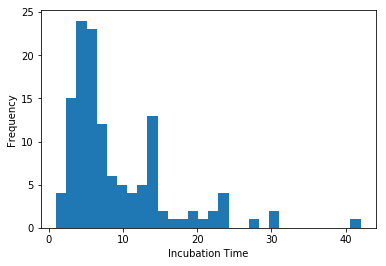

In [10]:
incubation_times = []
for t in texts:    
    for sentence in t.split('. '): # split into sentences by period, excluding decimal point.
        if 'incubation' in sentence:
            single_day = regex.findall(sentence)  # "a day", "a.b day"
            if len(single_day) == 1:  # to exclude comparisons of incubation time
                incubation_times.append(float(single_day[0][0])) # 
display(np.round(pd.Series(incubation_times).describe(), 2))
pd.Series(incubation_times).plot.hist(bins=30)
plt.xlabel('Incubation Time');

### Pandas: Vectorized String Functions
Robust: missing values are handled automatically by Pandas.

In [11]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve-li@gmail.com',
        'Rob': 'rob.NG@gmail.com', 'Wes': np.nan}
se = pd.Series(data)
se

Dave        dave@google.com
Steve    steve-li@gmail.com
Rob        rob.NG@gmail.com
Wes                     NaN
dtype: object

In [4]:
# Search a substring
se.str.contains('gmail')

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

#### Extract user names from the email addresses
Pandas Series Interact with RE

In [13]:
import re

user_pattern = r'([A-Z0-9._-]+)@[A-Z0-9.-]+\.[A-Z]{2,4}'
regex = re.compile(user_pattern, flags=re.IGNORECASE)

se.str.extract(regex)

,0
Dave,dave
Steve,steve-li
Rob,rob.NG
Wes,NaN


#### Extract city names from the addresses

In [86]:
flights_df = pd.read_csv('examples/flights_short.csv', nrows=5)
city_state = flights_df['ORIGIN_CITY_NAME']
city_state

0    Philadelphia, PA
1         Atlanta, GA
2      Sacramento, CA
3         Madison, WI
4          Newark, NJ
Name: ORIGIN_CITY_NAME, dtype: object

In [93]:
pattern = r"(.*), \D{2}" 
# \D{2}: non-digit with length 2
# .* : any character occurs 0 or more times
# (): target group

city_state.str.extract(pattern)

,0
0,Philadelphia
1,Atlanta
2,Sacramento
3,Madison
4,Newark
